# COVID-19 Forecast Using DARTS for Univariate and Multivariate Time-Series Forecasting
## DS 440 

In [37]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import seaborn as sns
from darts import TimeSeries
from darts.models import ExponentialSmoothing



# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
# read in dataset
df = pd.read_csv('covid.csv')

In [18]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2/24/2020,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2/25/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2/26/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2/27/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2/28/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [19]:
# Quantify rows and columns
df.shape

(155261, 67)

In [20]:
# List of columns
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

# Create different simple models for predicting number of cases for one region (I'm choosing USA)

In [21]:
# Subset data for only US data
df_us = df.loc[df['location'] == 'United States']

In [22]:
df_us.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
146768,USA,North America,United States,1/22/2020,1.0,NaN,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146769,USA,North America,United States,1/23/2020,1.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146770,USA,North America,United States,1/24/2020,2.0,1.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146771,USA,North America,United States,1/25/2020,2.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146772,USA,North America,United States,1/26/2020,5.0,3.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,-8925.0,-3.59,-2.63,-26.808639


In [72]:
# Subset for only the dates and total_cases columns

df_us_cases = df_us[['date', 'total_cases']]
df_us_deaths = df_us[['date', 'total_deaths']]
df_us_cases.head()

,date,total_cases
146768,1/22/2020,1.0
146769,1/23/2020,1.0
146770,1/24/2020,2.0
146771,1/25/2020,2.0
146772,1/26/2020,5.0


In [75]:
df_us_cases = df_us_cases.dropna()
df_us_deaths = df_us_deaths.dropna()
print(df_us_cases['total_cases'].isnull().sum())
print(df_us_cases['total_cases'].isna().sum())
print(df_us_deaths['total_deaths'].isnull().sum())
print(df_us_deaths['total_deaths'].isna().sum())

0
0
0
0


In [25]:
df_us_cases.tail()

,date,total_cases
147490,1/13/2022,64062060.0
147491,1/14/2022,64920670.0
147492,1/15/2022,65445434.0
147493,1/16/2022,65703875.0
147494,1/17/2022,66529280.0


In [76]:
# Need to set the date col to be a df index and format the date column to a date type
df_us_cases.index = pd.to_datetime(df_us_cases['date'], format='%m/%d/%Y')
df_us_deaths.index = pd.to_datetime(df_us_deaths['date'], format='%m/%d/%Y')

In [77]:
# Split the data into a training and testing set
# Training will be all data before December 2021 and Testing will be all data since then
train_cases = df_us_cases[df_us_cases.index < pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
test_cases = df_us_cases[df_us_cases.index >= pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
train_deaths = df_us_deaths[df_us_deaths.index < pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
test_deaths = df_us_deaths[df_us_deaths.index >= pd.to_datetime('2021-12-01', format='%Y-%m-%d')]


In [36]:
train_cases.reset_index(drop=True, inplace=True)
test_cases.reset_index(drop=True, inplace=True)
train_deaths.reset_index(drop=True, inplace=True)
test_deaths.reset_index(drop=True, inplace=True)

In [86]:
cases_series = TimeSeries.from_dataframe(df_us_cases, 'date', 'total_cases')
train_cases_series = TimeSeries.from_dataframe(train_cases, 'date', 'total_cases')
test_cases_series = TimeSeries.from_dataframe(test_cases, 'date', 'total_cases')
deaths_series = TimeSeries.from_dataframe(df_us_deaths, 'date', 'total_deaths')
train_deaths_series = TimeSeries.from_dataframe(train_deaths, 'date', 'total_deaths')
test_deaths_series = TimeSeries.from_dataframe(test_deaths, 'date', 'total_deaths')

In [87]:
model = ExponentialSmoothing()
model.fit(train_cases_series)
prediction = model.predict(len(test_cases_series)+60, num_samples=1000)

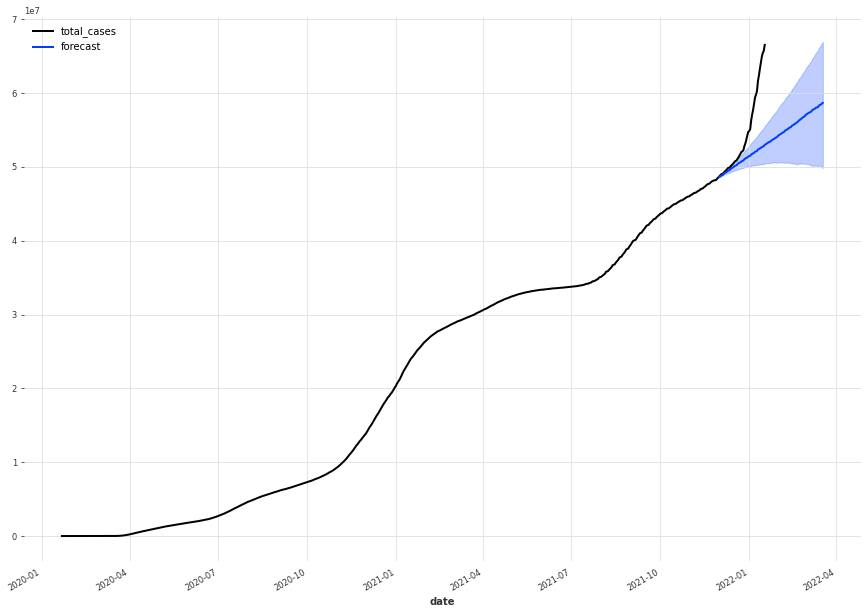

In [88]:
cases_series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]

In [89]:
model = ExponentialSmoothing()
model.fit(train_deaths_series)
prediction = model.predict(len(test_deaths_series)+60, num_samples=1000)

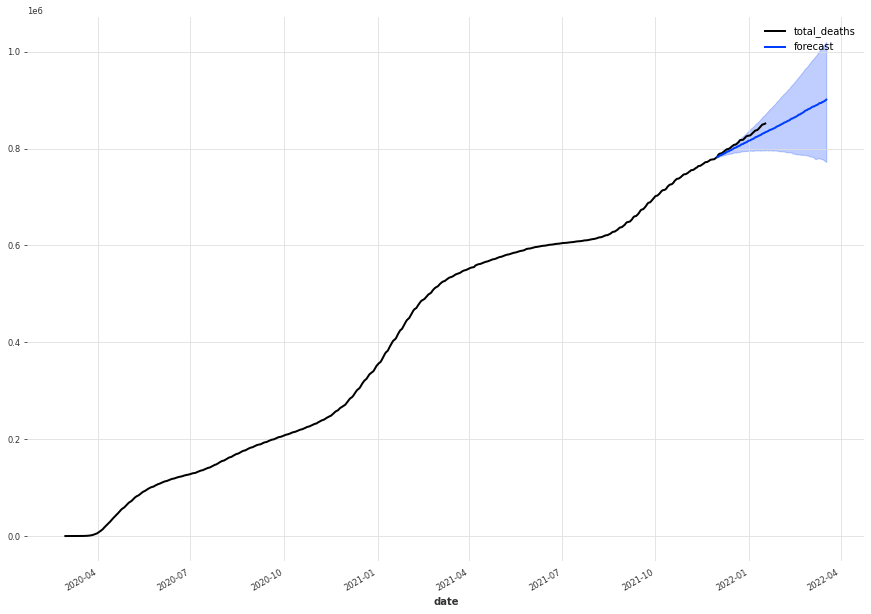

In [90]:
deaths_series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.rcParams['figure.figsize'] = [15, 10]